In [7]:
import numpy as np
import hist
import matplotlib.pyplot as plt
from scipy.integrate import quad
import os

# Fit functions definitions

In [8]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def VWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def PL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def DE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a2*np.exp(a3*x))

def expVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return np.exp(N*np.exp(-(x-mu)**2/(2*sig**2)))

def crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR):
    if (type(x) is float):
        x = np.array([x])
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.shape(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def datamodel(x,
            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2,
            Nbg, a1, a2, a3):
    return crystalball(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) \
        + crystalball(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2) \
        + expVWG(x, Nbg, a1, a2, a3)

#def mcmodel(x,
#            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
#            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2):
#    return crystalball(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) \
#        + crystalball(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2)


# Derivatives

def intervals(rel, alphaL, alphaR):
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    return I1, I2, I3


def dcbdN(x, N, mu, sig, alphaL, nL, alphaR, nR):
    if (type(x) is float):
        x = np.array([x])
    rel = (x-mu)/sig
    I1, I2, I3 = intervals(rel, alphaL, alphaR)
    res = np.zeros(np.shape(x))
    res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
    res[I2] = (np.exp(-(-mu + x)**2/(2*sig**2)))                                                                             [I2]
    res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
    return res

def dcbdmu(x, N, mu, sig, alphaL, nL, alphaR, nR):
    if (type(x) is float):
        x = np.array([x])
    rel = (x-mu)/sig
    I1, I2, I3 = intervals(rel, alphaL, alphaR)
    res = np.zeros(np.shape(x))
    res[I1] = (-N*nL*(nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(sig*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)) [I1]
    res[I2] = (-N*(2*mu - 2*x)*np.exp(-(-mu + x)**2/(2*sig**2))/(2*sig**2)                                                                                                                   ) [I2]
    res[I3] = (N*nR*(nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(sig*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR) ) [I3]
    return res

def dcbdsig(x, N, mu, sig, alphaL, nL, alphaR, nR):
    if (type(x) is float):
        x = np.array([x])
    rel = (x-mu)/sig
    I1, I2, I3 = intervals(rel, alphaL, alphaR)
    res = np.zeros(np.shape(x))
    res[I1] = (-N*nL*(nL/np.abs(alphaL))**nL*(-mu + x)*np.exp(-np.abs(alphaL)**2/2)/(sig**2*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)) [I1]
    res[I2] = (N*(-mu + x)**2*np.exp(-(-mu + x)**2/(2*sig**2))/sig**3                                                                                                                                     ) [I2]
    res[I3] = (N*nR*(nR/np.abs(alphaR))**nR*(-mu + x)*np.exp(-np.abs(alphaR)**2/2)/(sig**2*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR) ) [I3]
    return res

# Integration interval
x0, x1 = 1, 10

def IdcbdN(x, *args):
    return quad(dcbdN, x0, x1, args=args)[0]

def Idcbdmu(x, N, mu, sig, alphaL, nL, alphaR, nR):
    return quad(dcbdmu, x0, x1, args=args)[0]

def Idcbdsig(x, N, mu, sig, alphaL, nL, alphaR, nR):
    return quad(dcbdsig, x0, x1, args=args)[0]

def sig2cb(cov,  x, N, mu, sig, alphaL, nL, alphaR, nR):
    return IdcbdN(x, N, mu, sig, alphaL, nL, alphaR, nR)**2 * cov[0,0]
    +Idcbdmu(x, N, mu, sig, alphaL, nL, alphaR, nR)**2 * cov[1,1]
    +Idcbdsig(x, N, mu, sig, alphaL, nL, alphaR, nR)**2 * cov[2,2]
    +2*IdcbdN(x, N, mu, sig, alphaL, nL, alphaR, nR)*Idcbdmu(x, N, mu, sig, alphaL, nL, alphaR, nR) * np.sqrt(cov[0, 1])
    +2*IdcbdN(x, N, mu, sig, alphaL, nL, alphaR, nR)*Idcbdsig(x, N, mu, sig, alphaL, nL, alphaR, nR) * np.sqrt(cov[0, 2])
    +2*Idcbdmu(x, N, mu, sig, alphaL, nL, alphaR, nR)*Idcbdsig(x, N, mu, sig, alphaL, nL, alphaR, nR) * np.sqrt(cov[1, 2])
    
# test
#x = np.arange(2,4,0.01)
#p = [1, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038]
#y =  dcbdsig(x, *p) 
#plt.plot(x,y)
#IdcbdN(x,*p)

# Fit loop (over $p_T$ cuts)

/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)


[4.55671964e+03 3.09982601e+00 6.29620649e-02 8.56477234e-01
 3.11309364e+00 2.05460074e+00 1.50361309e+00 7.19524893e+01
 3.69660321e+00 5.93585320e-02 7.45529120e-01 4.99564973e+00
 2.30142894e+00 3.08316961e+00 1.01048253e+01 1.29059484e+00
 1.31999929e+00 5.41299727e-01]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)


[7.18213138e+03 3.10076751e+00 6.46397758e-02 8.64751130e-01
 4.06324732e+00 2.00065624e+00 1.31097097e+00 1.15051956e+02
 3.69614113e+00 6.18172606e-02 7.84804716e-01 4.94155776e+00
 2.17815662e+00 3.66203768e+00 8.67774808e+00 1.77850743e+00
 1.78863824e+00 7.03435225e-01]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)


[3.56012048e+03 3.09457816e+00 6.96025837e-02 9.07311958e-01
 4.97053178e+00 1.77320719e+00 1.75528387e+00 1.56659479e+01
 3.70016725e+00 6.57524848e-02 9.30185597e-01 3.21695468e+00
 2.09563504e+00 2.50581618e+00 6.93839436e+00 2.00397426e+00
 3.03738966e+00 1.92452691e-01]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)


[1.54961767e+03 3.09869258e+00 7.31842321e-02 9.67654831e-01
 4.95606533e+00 1.60518610e+00 3.35600326e+00 3.97231986e+01
 3.68395165e+00 7.01173689e-02 9.56320805e-01 3.22238755e+00
 1.72116923e+00 4.94529583e+00 5.73517000e+00 1.97977487e+00
 3.44244587e+00 2.57198169e-01]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)


[ 6.27803872e+02  3.09403924e+00  7.42782789e-02  1.06878465e+00
  3.61983074e+00  1.59830061e+00  2.13096278e+00  2.15643569e+01
  3.64291238e+00  6.99240183e-02  8.97109081e-01  4.15142326e+00
  1.36401583e+00  8.58877597e+00  4.84849172e+00  1.25802637e+00
  5.19478765e+00 -8.81772397e-02]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: overflow encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in multiply
  result[I3] = AR*(BR + rel[I3])**(-nR)
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in 

[2.91513676e+02 3.08849143e+00 7.24104449e-02 1.01184488e+00
 3.94745446e+00 1.27108899e+00 1.09988214e+01 1.80823941e+01
 3.71695988e+00 7.69277948e-02 1.02080011e+00 3.57549819e+00
 1.62749472e+00 3.63483899e+00 4.04262502e+00 1.83171629e+00
 2.41685621e+00 1.05760766e+00]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: overflow encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in multiply
  result[I3] = AR*(BR + rel[I3])**(-nR)
/tmp/ipykernel_547/581165928.py:26: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_547/581165928.py:38: RuntimeWarning: invalid value encountered in 

[2.23130184e+02 3.09000348e+00 7.46741027e-02 1.08504435e+00
 4.02322984e+00 1.21065565e+00 1.47616656e+02 2.31903949e+00
 3.60872613e+00 7.59380951e-02 7.75887392e-01 1.63555364e+01
 1.48805565e+00 3.27613939e+00 3.98304141e+00 1.61925894e+00
 5.52638320e-01 2.27980341e+00]


/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: overflow encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]


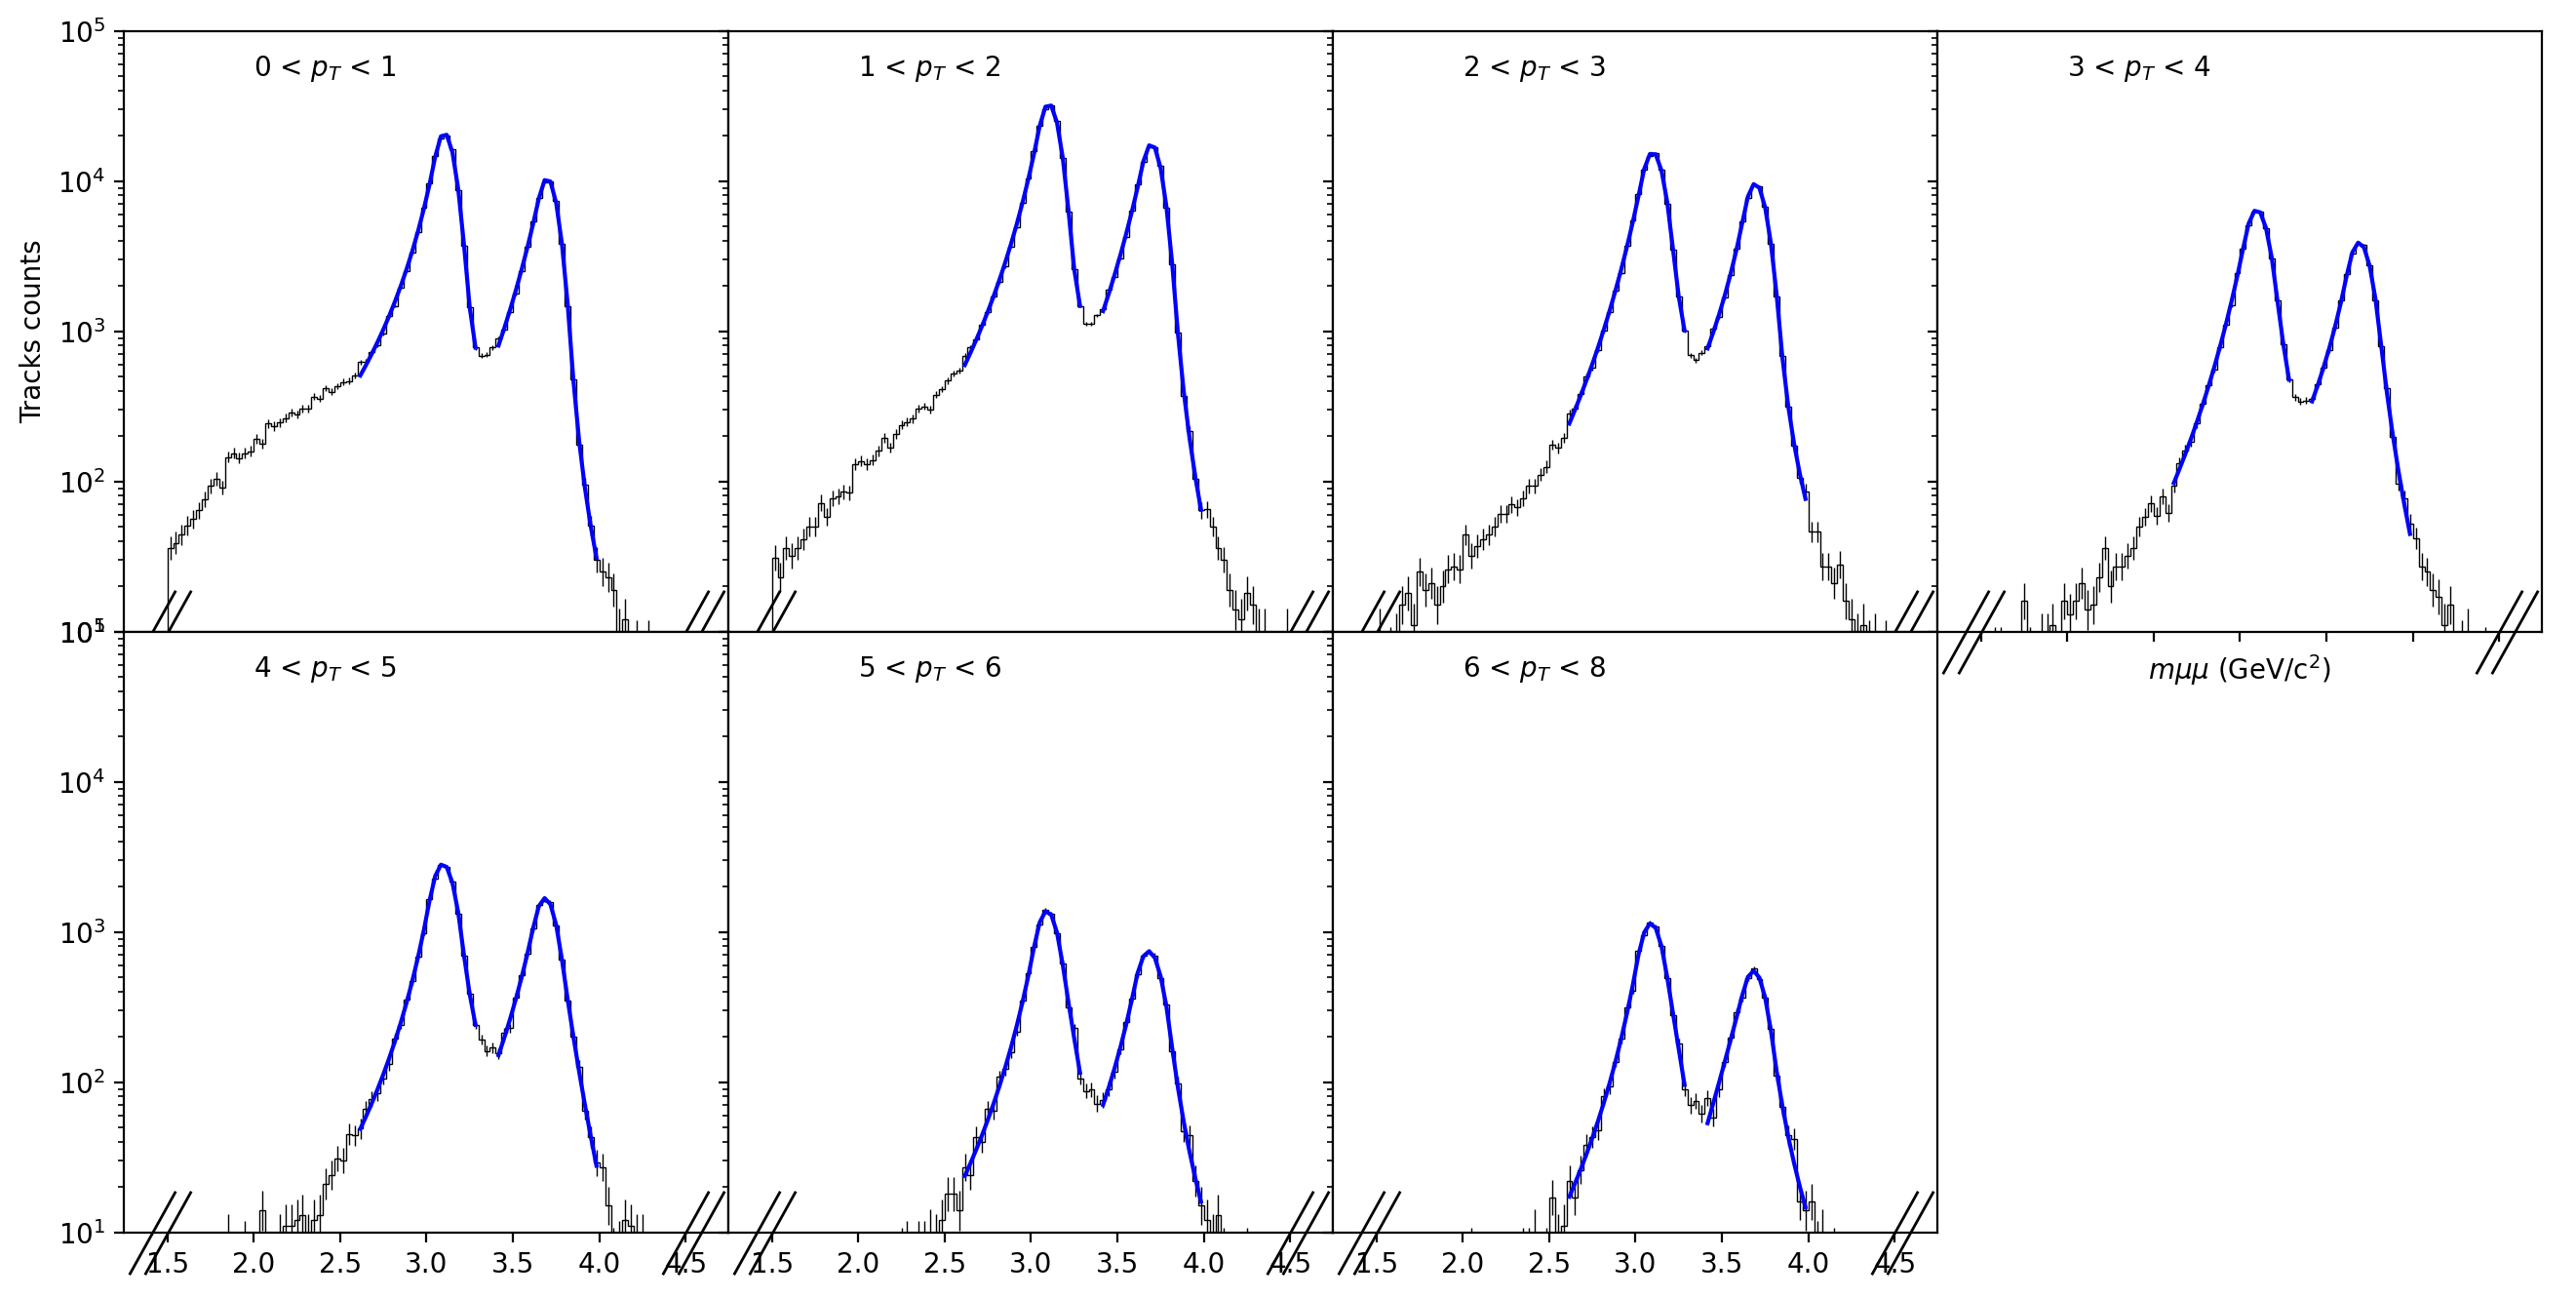

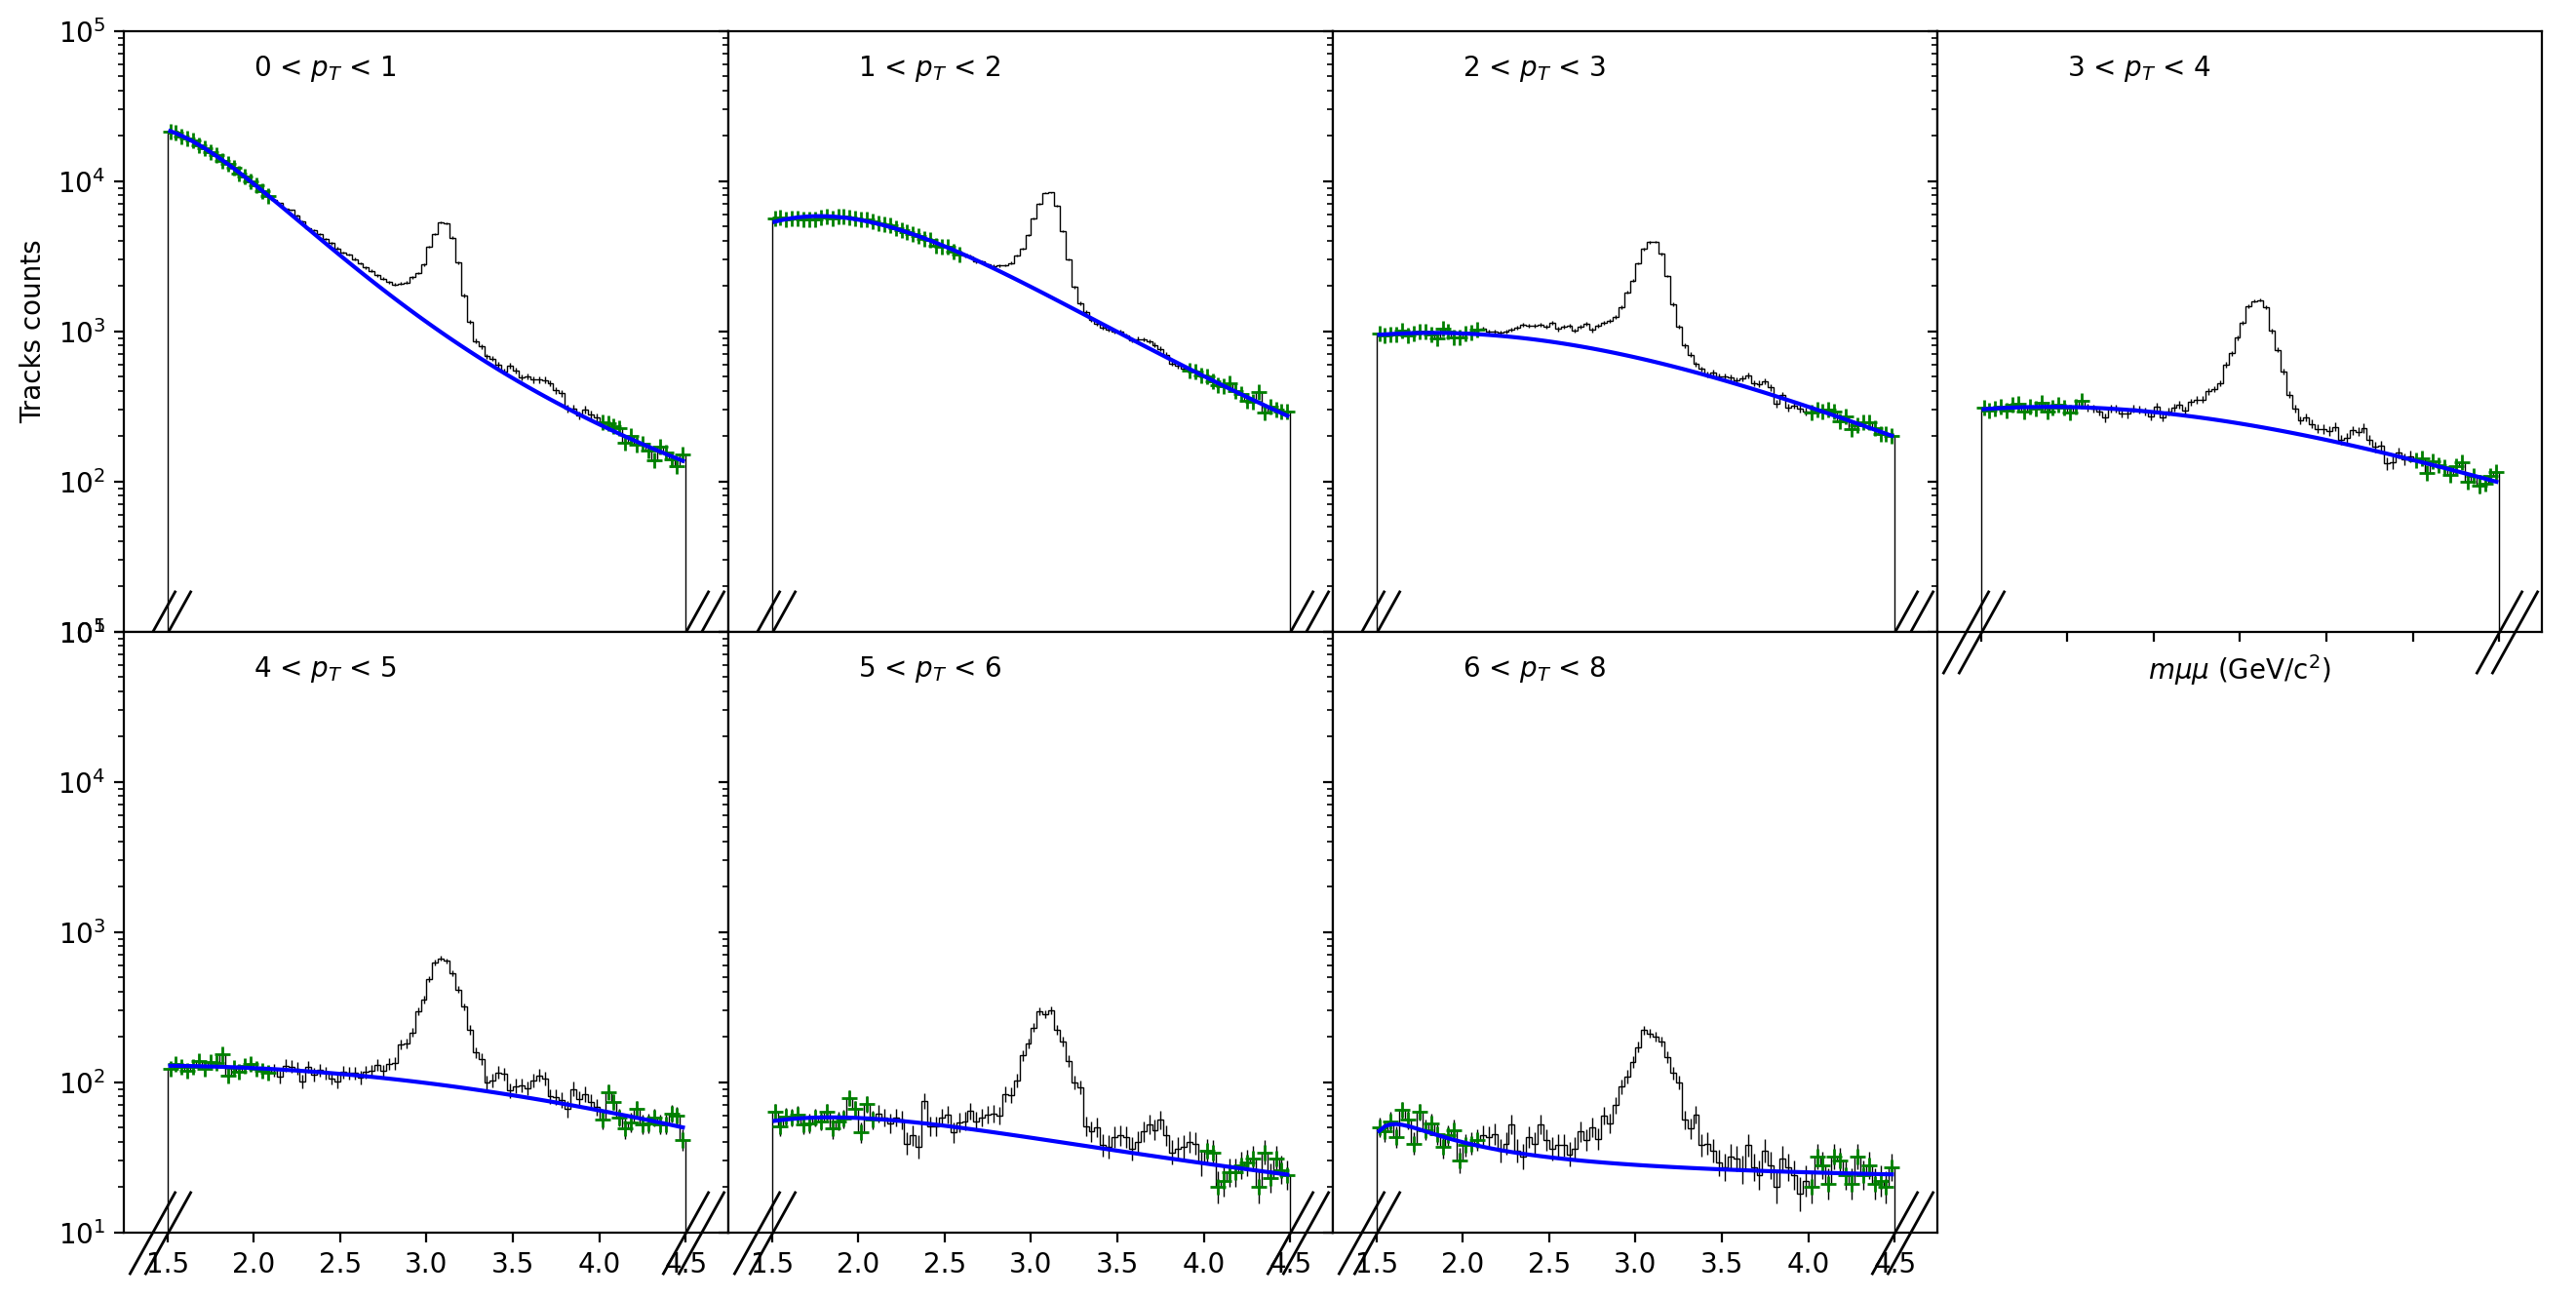

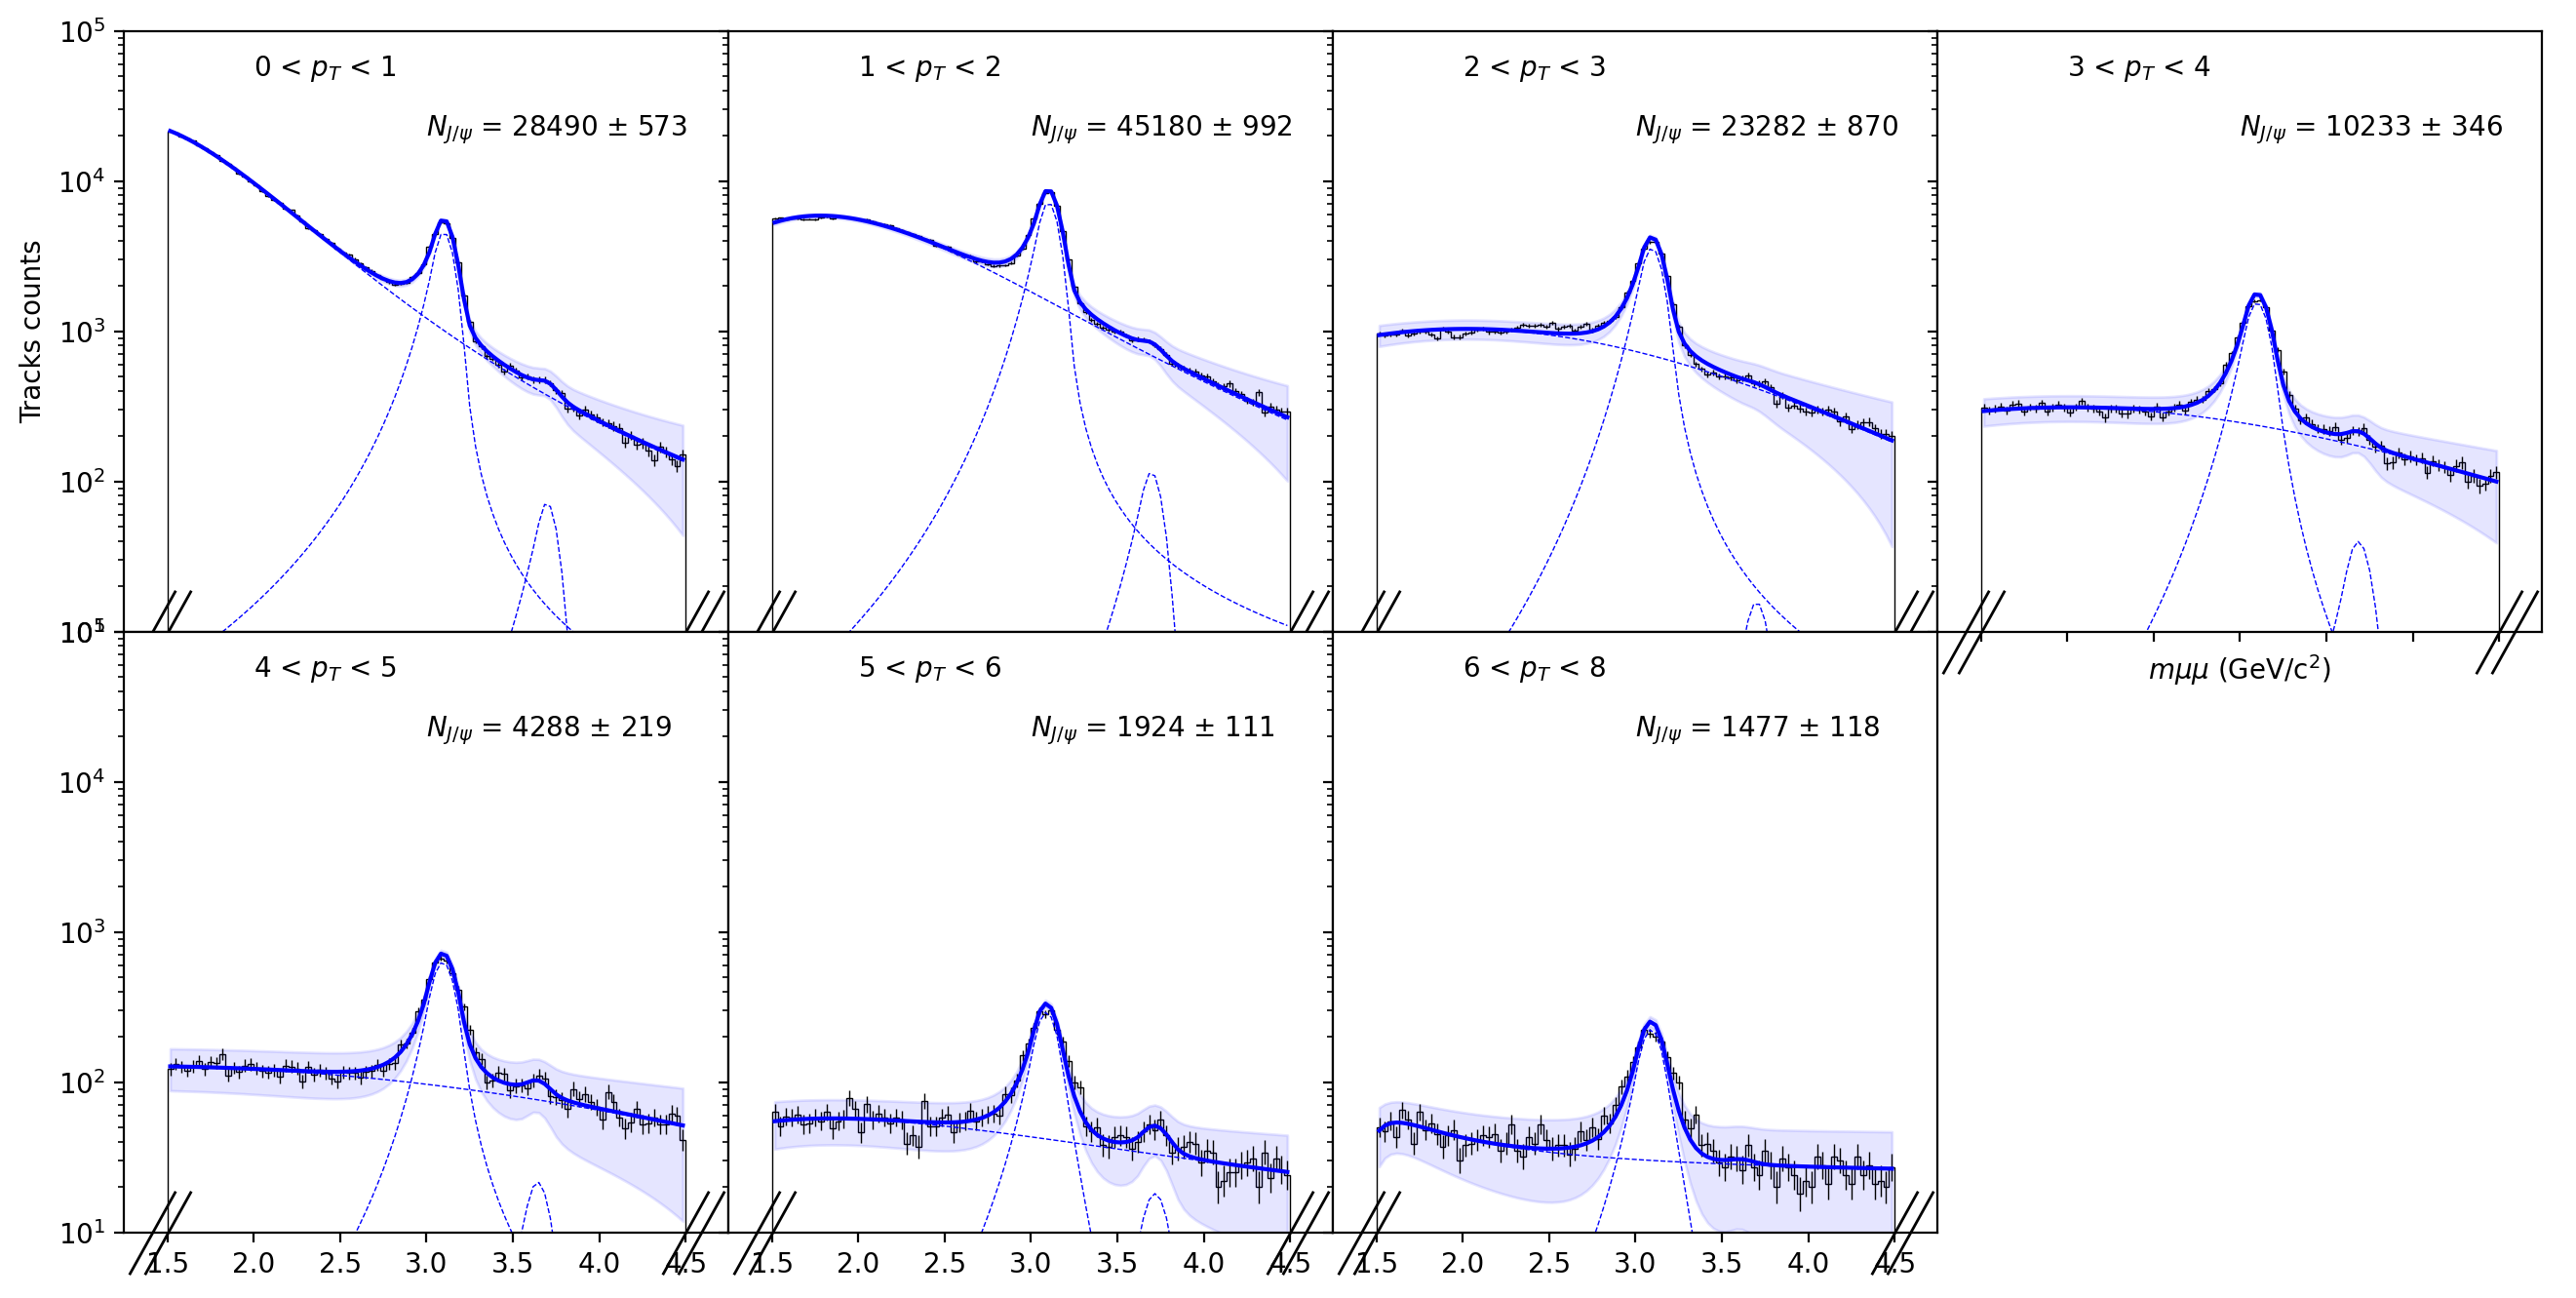

In [31]:
fit_on = True
nruns = 108  #  all: 108

def gethistdata(h,xmin,xmax):
    ''' Get data from histo '''
    y,x = h[xmin*1j:xmax*1j].to_numpy()
    x = x[:-1]+(x[1]-x[0])/2  # set x to middles instead of lower bound of bins
    return x,y

def fillhist(h,type,pTl,pTu):
    f = open(f'mass/{type}.CMUL_pT{pTl}-{pTu}.npy', 'rb')
    for i in range(nruns):
        A = np.load(f)
        #print(A)
        h.fill(A)
    f.close()
    
def setaxes(ax):
    ax.set_ylim(1e1,1e5)
    ax.set_yscale("log")
    ax.text(2, 5e4, f"{pTl} < $p_T$ < {pTu}")
    ax.set_xlabel('')
    if i==3: ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
    if i==0: ax.set_ylabel("Tracks counts")


def mklb(p0, var):
    return p0*(1-np.sign(p0)*var)

def mkub(p0, var):
    return p0*(1+np.sign(p0)*var)

nbin = 90
massmin = 1.5
massmax = 4.5
dmass = (massmax-massmin)/nbin

fig = []
axs = []
for i in range(3):
    fig.append(plt.figure(i+1, dpi=200, figsize=(16,8)))
    gs = fig[i].add_gridspec(2, 4, hspace=0, wspace=0)
    axs.append(gs.subplots(sharex='col', sharey='row'))
    axs[i][1,-1].remove()
    

IJPsi_pT = []

pTcuts = [0,1,2,3,4,5,6,8]
for i in range(len(pTcuts)-1):
    pTl = pTcuts[i]
    pTu = pTcuts[i+1]

    # Fill histograms
    hmc =   hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    fillhist(hmc,'mc',pTl,pTu)
    fillhist(hdata,'data',pTl,pTu)
    
    mass,Nmc = gethistdata(hmc,massmin,massmax)
    mass,Ndata = gethistdata(hdata,massmin,massmax)
    
    
    ##########################
    #  MC Crystal Balls fit  #
    ##########################
    
    if 1:
        ax = axs[0].flatten()[i]
        hmc.plot(ax=ax, label="Selected events", color='black', ls='-', lw=0.5);
        setaxes(ax)
        
        # Intervals for fit
        Dnul = Nmc==0
        DJPsi = (2.6<mass)*(mass<3.3) * ~Dnul
        DPsi2S = (3.4<mass)*(mass<4.0) * ~Dnul


        # p0

        p0JPsi = np.array([(hmc[3.10*1j]), 3.10, 7.29e-02, 9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01])
        p0Psi2S = np.array([(hmc[3.68*1j]), 3.68, 7.29e-02, 9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01])
        #ax.plot(mass[DJPsi],(crystalball(mass,*p0JPsi))[DJPsi],':r', alpha=0.5,label="")
        #ax.plot(mass[DPsi2S],(crystalball(mass,*p0Psi2S))[DPsi2S],':r', alpha=0.5,label="")
        #print('p0 J/psi:', p0JPsi)
        #print('p0 psi(2S):', p0Psi2S)
        
 
        # Fit JPsi and Psi2S independently
        if fit_on:
            try:
                pfitJPsi, _ = curve_fit(crystalball, mass[DJPsi], Nmc[DJPsi], sigma=np.sqrt(Nmc[DJPsi]), p0=[*p0JPsi], method='trf')
                pfitPsi2S, _ = curve_fit(crystalball, mass[DPsi2S], (Nmc[DPsi2S]), sigma=np.sqrt(Nmc[DPsi2S]), p0=[*p0Psi2S], method='trf')

                ax.plot(mass[DJPsi], (crystalball(mass,*pfitJPsi))[DJPsi], 'b')
                ax.plot(mass[DPsi2S], (crystalball(mass,*pfitPsi2S))[DPsi2S], 'b')
            except Exception as e:
                #raise(e)
                pass

        # Charlig tails p0
        p0JPsi[:] = [40248.03611688854, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038]
       
    
    #########################
    #  Data background fit  #
    #########################
    
    if 1:
        # Remove JPsi and Psi2S intervals from data in order to fit the background only
        if i==1:
            Dbg = ~((2.6<mass)*(mass<3.9))
        else:    
            Dbg = ~((2.1<mass)*(mass<4.0))
        
        ax = axs[1].flatten()[i]
        hdata.plot(ax=ax, color='black',ls='-',lw=0.5)
        ax.plot(mass[Dbg],Ndata[Dbg],'+g')
        setaxes(ax)

        #p0 = [1e3, -1, 1e2, -3]
        #bounds = ([0, -10, 0, -10],[1e5, 0, 1e4, 0])
        #ax.plot(mass,(DE(mass,*p0)))
        
        # Fit bg
        if fit_on:
            try:
                pfitbg, covbg = curve_fit(expVWG, mass[Dbg], (Ndata[Dbg]), sigma=np.sqrt(Ndata[Dbg]), method='trf')
                ax.plot(mass,(expVWG(mass,*pfitbg)),'b')
            except Exception as e:
                #raise(e)
                pass

    ###############
    #  Final fit  #
    ###############
    
    if 1:
        ax = axs[2].flatten()[i]
        hdata.plot(ax=ax,label="Selected events",color='black',ls='-',lw=0.5)
        setaxes(ax)
        
        if fit_on:
            # bounds
            varbg = np.ones(np.shape(pfitbg))*0.1 # bg parameters variation factor around p0
            varpks = np.array([10, 0.02, 0.02, *0.001*np.ones(4)])  # peaks parameters variation factor around p0
            lb = np.array([*mklb(pfitJPsi,varpks), *mklb(pfitPsi2S,varpks), *mklb(pfitbg,varbg)])
            ub = np.array([*mkub(pfitJPsi,varpks), *mkub(pfitPsi2S,varpks), *mkub(pfitbg,varbg)])
            bounds = (lb,ub)
            
            # Set p0 peaks amplitudesfrom data
            pfitJPsi[0] = (hdata[pfitJPsi[1]*1j])
            pfitPsi2S[0] = (hdata[pfitPsi2S[0]*1j])
            
            try:
                pfit, cov = curve_fit(
                    datamodel, mass, (Ndata),
                    sigma=np.sqrt(Ndata),
                    p0=[*pfitJPsi, *pfitPsi2S, *pfitbg],
                    bounds=bounds,
                    method='trf')                
                #print(pfit)

                Nfit = datamodel(mass,*pfit)
                NJPsi = crystalball(mass,*pfit[:7])
                NPsi2S = crystalball(mass,*pfit[7:14])
                ax.plot(mass, Nfit,'b')
                ax.plot(mass, NJPsi,'--b',lw=0.5)
                ax.plot(mass, NPsi2S,'--b',lw=0.5)
                ax.plot(mass,(expVWG(mass,*pfit[14:])),'--b',lw=0.5)
                
                #print(cov/abs(pfit))
                # Fit error
                cov[3:7] = 0
                cov[10:14] = 0
                errfit = np.sqrt(np.sum(np.diag(cov)))

                ax.fill_between(mass, Nfit-errfit, Nfit+errfit, color='blue', alpha=0.1) 
                
                # J/psi Integral
                IJPsi = quad(crystalball, x0, x1, args=tuple(pfit[:7]))[0]

                # J/psi Integral error
                errJPsi = np.sqrt(sig2cb(cov[:7,:7], mass, *pfit[:7]))
                ax.text(3, 2e4, f'$N_{{J/\psi}}$ = {IJPsi/dmass:.0f} $\pm$ {errJPsi/dmass:.0f}')
                #print(IJPsi/dmass)
                #print(errJPsi/dmass)
            except Exception as e:
                raise(e)
                pass
            
fig[0].savefig('fig/MC_fit.pdf')
fig[1].savefig('fig/bg_fit.pdf')
fig[2].savefig('fig/final_fit.pdf')

/tmp/ipykernel_547/581165928.py:72: RuntimeWarning: invalid value encountered in power
  res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
/tmp/ipykernel_547/581165928.py:74: RuntimeWarning: invalid value encountered in power
  res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]


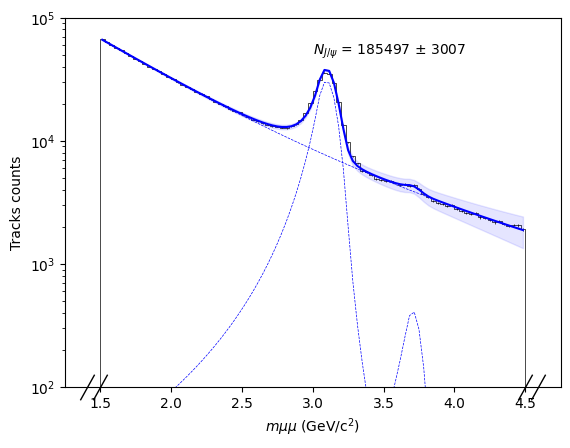

In [58]:
def fillhist(h, type):
    f = open(f'mass/{type}.CMUL.npy', 'rb')
    for i in range(nruns):
        A = np.load(f)
        h.fill(A)
    f.close()

# Fill histograms
#hmc = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))


#fillhist(hmc, 'mc')
fillhist(hdata, 'data')

mass, Ndata = gethistdata(hdata,massmin,massmax)


fig = plt.figure()
ax = plt.gca()

hdata.plot(label="Selected MC events",color='black',ls='-',lw=0.5)

#########################
#  Data background fit  #
#########################

if 1:
    # Remove JPsi and Psi2S intervals from data in order to fit the background only
    Dbg = ~((2.3<mass)*(mass<4.0))

    # Fit bg
    if fit_on:
        try:
            pfitbg, covbg = curve_fit(expVWG, mass[Dbg], (Ndata[Dbg]), sigma=np.sqrt(Ndata[Dbg]), method='trf')
            
        except Exception as e:
            #raise(e)
            pass


if 1:
    #p0JPsi = [40248, 3.09982601e+00, 6.29620649e-02, 8.56477234e-01, 3.11309364e+00, 2.05460074e+00, 1.50361309e+00]
    p0JPsi = [40248.03611688854, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038] # Ch
    p0Psi2S = [3e3, 3.69660321e+00, 5.93585320e-02, 7.45529120e-01, 4.99564973e+00, 2.30142894e+00, 3.08316961e+00]

    # bounds
    varbg = np.ones(np.shape(pfitbg))*0.1 # bg parameters variation factor around p0
    varpks = np.array([10, 0.1, 0.1, *0.01*np.ones(4)])  # peaks parameters variation factor around p0
    lb = np.array([*mklb(p0JPsi,varpks), *mklb(p0Psi2S,varpks), *mklb(pfitbg,varbg)])
    ub = np.array([*mkub(p0JPsi,varpks), *mkub(p0Psi2S,varpks), *mkub(pfitbg,varbg)])
    bounds = (lb,ub)

    # Set p0 peaks amplitudesfrom data
    #p0JPsi[0] = (hdata[p0JPsi[1]*1j])
    #p0Psi2S[0] = (hdata[p0Psi2S[0]*1j])

    try:
        pfit, cov = curve_fit(
            datamodel, mass, (Ndata),
            sigma=np.sqrt(Ndata),
            p0=[*p0JPsi, *p0Psi2S, *pfitbg],
            bounds=bounds,
            method='trf')
        
        Nfit = datamodel(mass,*pfit)
        NJPsi = crystalball(mass,*pfit[:7])
        NPsi2S = crystalball(mass,*pfit[7:14])
        ax.plot(mass, Nfit,'b')
        ax.plot(mass, NJPsi,'--b',lw=0.5)
        ax.plot(mass, NPsi2S,'--b',lw=0.5)
        ax.plot(mass,(expVWG(mass,*pfit[14:])),'--b',lw=0.5)
        
        #print(cov/abs(pfit))
        # Fit error
        cov[3:7] = 0
        cov[10:14] = 0
        errfit = np.sqrt(np.sum(np.diag(cov)))

        ax.fill_between(mass, Nfit-errfit, Nfit+errfit, color='blue', alpha=0.1) 

        # J/psi Integral
        IJPsi = quad(crystalball, x0, x1, args=tuple(pfit[:7]))[0]

        # J/psi Integral error
        errJPsi = np.sqrt(sig2cb(cov[:7,:7], mass, *pfit[:7]))
        ax.text(3, 5e4, f'$N_{{J/\psi}}$ = {IJPsi/dmass:.0f} $\pm$ {errJPsi/dmass:.0f}')
        #print(IJPsi/dmass)
        #print(errJPsi/dmass)
    
    except Exception as e:
        raise(e)
        pass

# plot p0
#ax.plot(mass[Dbg],Ndata[Dbg],'+g')
#ax.plot(mass,(expVWG(mass,*pfitbg)),'g')
#ax.plot(mass, crystalball(mass,*p0JPsi),'g')
#ax.plot(mass, crystalball(mass,*p0Psi2S),'g')

ax.set_ylim(1e2,1e5)
ax.set_yscale("log")
#ax.text(2, 5e4, f"")
ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
ax.set_ylabel("Tracks counts")

fig.savefig('fig/all_pT_final_fit.pdf')

#fig2 = plt.figure(3)
#hdata.plot(label="Selected data events",color='black',ls='-',lw=0.5)


